#**DOENÇA CARDÍACA DATASET**

## Modelo Ensemble (Random Forest)

Equipe: Nicolas Zocche e Alejandra Osorio

## Descrição das variáveis:


1. Age: idade do paciente [anos]
2. Sex: sexo do paciente [M: Masculino, F: Feminino]
3. ChestPainType: tipo de dor no peito [TA: Angina típica, ATA: Angina atípica, NAP: Dor não anginosa, ASY: Assintomática]
4. RestingBP: pressão arterial em repouso [mm Hg]
5. Cholesterol: colesterol sérico [mm/dl]
6. FastingBS: glicemia em jejum [1: se FastingBS > 120 mg/dl, 0: caso contrário]
7. RestingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: com anormalidade da onda ST-T (inversões da onda T e/ou elevação ou depressão do segmento ST de > 0,05 mV), HVE: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes]
8. MaxHR: frequência cardíaca máxima atingida [Valor numérico entre 60 e 202]
9. ExerciseAngina: angina (dor no peito causada pela diminuição do fluxo de sangue no coração) induzida por exercício [S: Sim, N: Não]
10. Oldpeak: pico anterior do segmento ST [Valor numérico medido em depressão. E quanto maior a depressão pior. O normal é que seja horizontal, sem picos para cima ou baixo.]
11. ST_Slope: a inclinação do segmento ST do pico do exercício [Up: inclinação ascendente, Flat: plano, Down: inclinação descendente, o ideal é que seja plano.]
12. HeartDisease: classe de saída [1: doença cardíaca, 0: normal]



## Importação de Bibliotecas e do Dataset

In [18]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

import warnings
warnings.simplefilter(action='ignore', category=Warning)

path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1


In [2]:
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/root/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1/heart.csv


In [3]:
csv_file = '/root/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1/heart.csv'
df = pd.read_csv(csv_file)

## Análise Exploratória

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Verificando o balanceamento do Dataset

In [6]:
df['HeartDisease'].value_counts()

,count
HeartDisease,
1,508
0,410


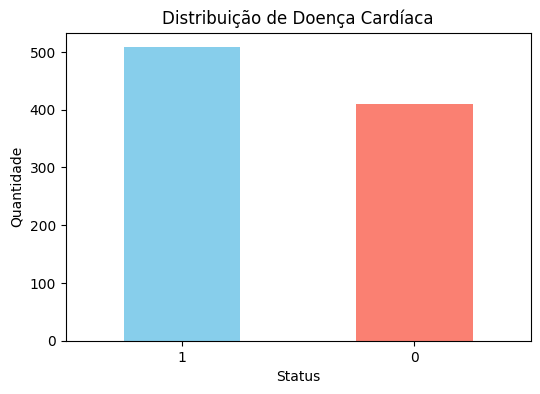

In [7]:
y_counts = df['HeartDisease'].value_counts()

y_counts.plot(kind='bar', color=['skyblue', 'salmon'], figsize=(6, 4))

plt.title('Distribuição de Doença Cardíaca')
plt.xlabel('Status')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

### Correlações

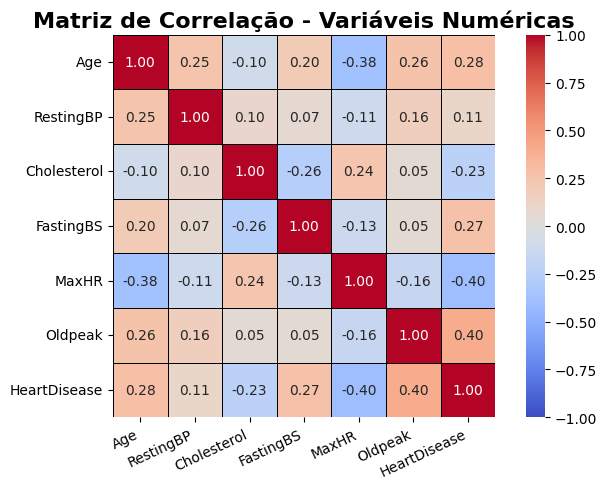

In [8]:
numerical_df = df.select_dtypes(include=['number'])

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(correlation_matrix,
                      annot=True,
                      fmt=".2f",
                      cmap='coolwarm',
                      vmin=-1,
                      vmax=1,
                      square=True,
                      linewidths=.5,
                      linecolor='black')

plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=16, fontweight='bold')
plt.xticks(rotation=25, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Conclusão:**

* As variáveis "Oldpeak" (pico anterior da depressão do seguimento ST) e "MaxHR" (frequência cardíaca máxima) têm as correlações mais significativas com "HeartDisease" indicando que esses dois fatores podem ser mais importantes para prever a presença de doença cardíaca do que outras variáveis como "Cholesterol" e "RestingBP". Enquanto a variável "Oldpeak" tem uma correlação positiva, o que pode indicar a existência da doença, a variável "MaxHR" tem correlação negativa, e pode indicar uma boa saúde cardíaca.
* A correlação entre "Age" e "HeartDisease" é positiva, mas fraca, sugerindo que a idade pode ter algum efeito, mas não é um indicador muito forte.


## Pipeline Pré-processamento

### Divisão de variáveis categóricas e numéricas, dropando apenas a variável alvo (HeartDisease), as demais serão utilizadas, por isso, mantidas.

In [9]:
categorical_features = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']

numerical_features = ['RestingBP',
                      'Age',
                      'Cholesterol',
                      'FastingBS',
                      'MaxHR',
                      'Oldpeak',
                      ]

### Modelo1 - sem hiperparâmetros

In [10]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
]
)

In [11]:
model1 = RandomForestClassifier(random_state=42)

In [12]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model1)
])

In [13]:
X = df.drop(['HeartDisease'], axis=1)

y = df['HeartDisease']

### Divisão de Treino e Teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.3,
    random_state=42,
    )

### Treinamento do Modelo

In [15]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RestingBP', 'Age',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model', RandomForestClassifier(random_state=42))])

### Predição

In [16]:
y_pred = pipeline.predict(X_test)

### Visualização de métricas

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       112
           1       0.91      0.90      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



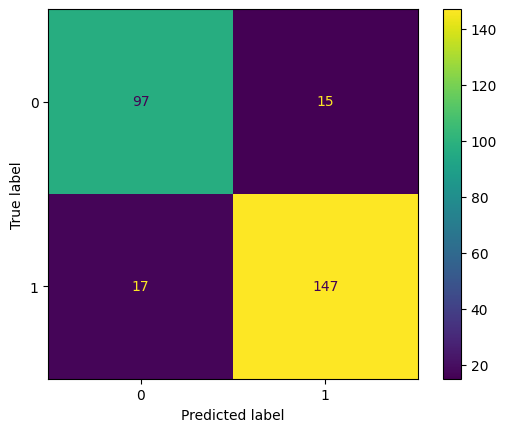

In [17]:
report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)

cm_modelo1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [21]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

scores1 = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=5)



{'fit_time': array([0.20021462, 0.19165468, 0.20444345, 0.19295382, 0.20309734]),
 'score_time': array([0.0199914 , 0.0221777 , 0.02004123, 0.01942968, 0.01850986]),
 'test_accuracy': array([0.87596899, 0.88372093, 0.859375  , 0.8359375 , 0.8515625 ]),
 'test_precision': array([0.90769231, 0.85526316, 0.88059701, 0.82432432, 0.81818182]),
 'test_recall': array([0.85507246, 0.94202899, 0.85507246, 0.88405797, 0.92647059]),
 'test_f1': array([0.88059701, 0.89655172, 0.86764706, 0.85314685, 0.86896552])}

### Modelo 2 (com ajuste de hiperparâmetros aleatórios/razoáveis)

In [22]:
model2 = RandomForestClassifier(
        n_estimators=50,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
)

### Pipeline para o Modelo 2

In [23]:
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model2)
])

### Divisão de Treino e Teste do Modelo 2

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.3,
    random_state=42,
    stratify=None
    )

### Treinamento do Modelo 2

In [25]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RestingBP', 'Age',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=50,
                                        random_state=42))])

Predição do Modelo 2

In [ ]:
y_pred = pipeline2.predict(X_test)

### Visualização de métricas e matriz de confusão

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       112
           1       0.91      0.90      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



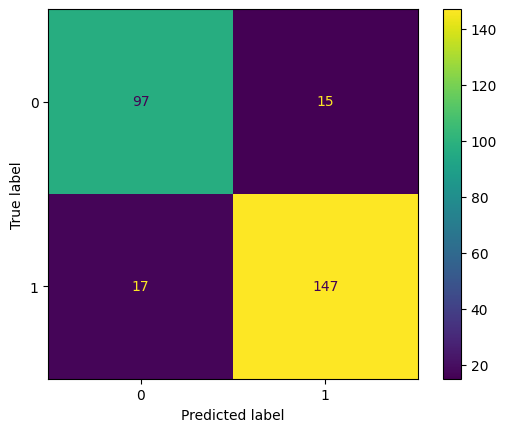

In [26]:
report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)

cm_modelo2 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [28]:
scores2 = cross_validate(pipeline2, X_train, y_train, scoring=scoring, cv=5)

scores2

{'fit_time': array([0.16172647, 0.18852329, 0.18147182, 0.15803957, 0.18600869]),
 'score_time': array([0.02515864, 0.02472329, 0.02703118, 0.02476692, 0.06402087]),
 'test_accuracy': array([0.87596899, 0.87596899, 0.875     , 0.8125    , 0.828125  ]),
 'test_precision': array([0.90769231, 0.85333333, 0.87323944, 0.79220779, 0.80263158]),
 'test_recall': array([0.85507246, 0.92753623, 0.89855072, 0.88405797, 0.89705882]),
 'test_f1': array([0.88059701, 0.88888889, 0.88571429, 0.83561644, 0.84722222])}

Conclusão: o f1-score manteve  uma boa consistência, com média de 86,75% e pequena oscilação (max 88,88% - min 83,56%), o que indica que ele consegue identificar bem casos positivos e evitar falsos positivos.

### Aplicação do GridSearch para encontrar os melhores hiperparâmetros

In [ ]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(pipeline2, param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}


### Modelo3 com parâmetros ajustados

In [29]:
model3 = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        )

In [30]:
pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model3)
])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.3,
    random_state=42,
    stratify=y
    )

In [32]:
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RestingBP', 'Age',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=5,
                                        random_state=42))])

In [33]:
y_pred = pipeline3.predict(X_test)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       123
           1       0.89      0.92      0.91       153

    accuracy                           0.89       276
   macro avg       0.90      0.89      0.89       276
weighted avg       0.90      0.89      0.89       276



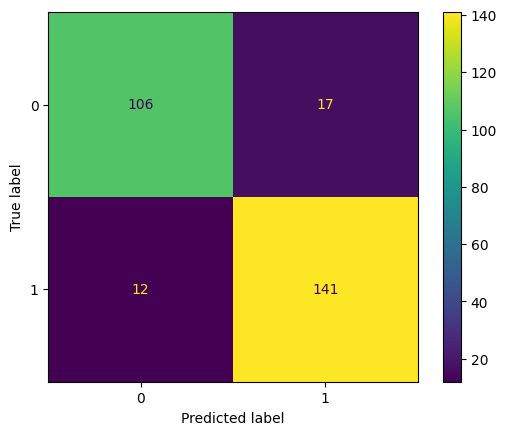

In [34]:
report = classification_report(y_test, y_pred)
print(report)

#confusion_matrix(y_test, y_pred)

cm_modelo3 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [39]:
scores3 = cross_validate(pipeline3, X_train, y_train, scoring=scoring, cv=5)

scores3

{'fit_time': array([0.31025004, 0.33780265, 0.32026505, 0.34597087, 0.34325314]),
 'score_time': array([0.03836823, 0.02906251, 0.03117275, 0.03108597, 0.05784988]),
 'test_accuracy': array([0.8372093 , 0.84496124, 0.875     , 0.8828125 , 0.7890625 ]),
 'test_precision': array([0.8125    , 0.88059701, 0.88732394, 0.87837838, 0.78947368]),
 'test_recall': array([0.91549296, 0.83098592, 0.88732394, 0.91549296, 0.84507042]),
 'test_f1': array([0.86092715, 0.85507246, 0.88732394, 0.89655172, 0.81632653])}

Conclusão com foco no f1 score: com uma média de 86,1%, o modelo mantém um bom equilíbrio entre identificar casos positivos e evitar falsos positivos.

**Conclusão final do modelo e próximos passos**

O modelo tem um desempenho satisfatório mas há espaço para melhorias, como testar o aprofundamento das árvores, mas sempre controlando para não gerar overfiting.